In [2]:
import os
import matplotlib.pyplot as plt
import pydicom
import numpy as np

from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt


# Change filename, file types
when we got the data, even it was DICOM file, the file names were wrong, we need to fix them by appending .dcm

In [ ]:
# import os

def rename_files_in_directory(directory):
    for root, dirs, files in os.walk(directory, topdown=True):
        # Skip directories named "CI Data" or "Processed"
        if "CI Data" in root.split(os.sep) or "Processed" in root.split(os.sep):
            continue

        for filename in files:
            # Skip files starting with '._'
            if filename.startswith("._"):
                continue  # Skip this file and move to the next one

            old_file = os.path.join(root, filename)

            # Check if the file starts with 'I' and does not end with '.dcm'
            if filename.startswith("I") and not filename.lower().endswith(".dcm"):
                new_file = old_file + ".dcm"
                try:
                    os.rename(old_file, new_file)
                    print(f"Renamed '{filename}' to '{filename}.dcm'")
                except FileNotFoundError as e:
                    print(f"Error processing file {filename}: {e}")

def delete_prefixed_files(directory):
    for root, dirs, files in os.walk(directory, topdown=True):
        # Skip directories named "CI Data" or "Processed"
        if "CI Data" in root.split(os.sep) or "Processed" in root.split(os.sep):
            continue

        for filename in files:
            # Delete files starting with '._'
            if filename.startswith("._"):
                file_path = os.path.join(root, filename)
                try:
                    os.remove(file_path)
                    print(f"Deleted: {filename}")
                except FileNotFoundError as e:
                    print(f"Error deleting file {filename}: {e}")
                except Exception as e:
                    print(f"Unexpected error deleting file {filename}: {e}")



# Example usage
directory = "/Volumes/Yunyao-2024"
rename_files_in_directory(directory)
delete_prefixed_files(directory)

# Build up data structure

- CI data
    - Patient ID
        - DICOM
        - Coronal
        - Electrode

    - Patient ID
        - DICOM
        - Coronal
        - Elelctrode
    ...

Where DICOM collect all the medical image of the patient, "coronal" select all the images that on coronal plane, "electrode" collect all the images that can clearly see the electrodes of coclea implant 


In [11]:
# import os
# import shutil

# base_folder = "/Volumes/Yunyao-2024/CI Data"

# for patient_id in range(200, 211):  # 200 to 210 inclusive
#     patient_base_folder = os.path.join(base_folder, str(patient_id))

#     # Create 'Coronal' and 'Electrode' folders parallel to 'DICOM' folder
#     coronal_folder = os.path.join(patient_base_folder, "Coronal")
#     electrode_folder = os.path.join(patient_base_folder, "Electrode")

#     # Create the folders if they don't exist
#     os.makedirs(coronal_folder, exist_ok=True)
#     os.makedirs(electrode_folder, exist_ok=True)

#     # Loop through all DICOM files in the patient's DICOM folder
#     for file in os.listdir(patient_folder):
#         if file.endswith('.dcm'):  # Make sure it's a DICOM file
#             file_path = os.path.join(patient_folder, file)

#             # Your logic to determine where the file should go
#             # For example:
#             # if is_coronal_scan(file_path):
#             #     shutil.move(file_path, coronal_folder)
#             # elif is_electrode_scan(file_path):
#             #     shutil.move(file_path, electrode_folder)

#             # Dummy logic for demonstration (replace with your own logic)
#             # Currently, this just prints a message instead of moving files
#             if "coronal" in file.lower():
#                 print(f"Moving {file} to {coronal_folder}")
#                 # shutil.move(file_path, coronal_folder)
#             elif "electrode" in file.lower():
#                 print(f"Moving {file} to {electrode_folder}")
#                 # shutil.move(file_path, electrode_folder)

# Quick preview of the CT images
- from this section we also know, the desired orientation (Coronal Plance) are [1,-0,-0,0,0,-1]

In [4]:
# Directory where your DICOM files are stored
# dicom_folder = "/Users/yunyao/Desktop/Capstone/Data/200/DICOM"
# dicom_folder = "/Volumes/Yunyao-2024/CI Data/205/DICOM"
# dicom_folder = "/Volumes/Yunyao-2024/CI Data/205/Coronal"
dicom_folder = "/Volumes/Yunyao-2024/CI Data/200-210/204/Coronal"

# List all DICOM files in the folder
dicom_files = [f for f in os.listdir(dicom_folder)]

def show_dicom_image(file_index):
    try:
        file_path = os.path.join(dicom_folder, dicom_files[file_index])
        dicom_data = pydicom.dcmread(file_path, force=True)

        # Extract patient ID and orientation
        patient_id = dicom_data.get("PatientID", "Not available")
        image_orientation_patient = dicom_data.get("ImageOrientationPatient", "Not available")
        
        # If image position patient is available, round the coordinates
        if image_orientation_patient != "Not available":
            image_orientation_patient = [round(coord, 0) for coord in image_orientation_patient]

        # Display the image
        plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)
        
        # Set the title with the filename, patient ID, and orientation
        plt.title(f"Filename: {dicom_files[file_index]}\n"
                  f"Patient ID: {patient_id}\n"
                  f"Image Oriantation Patient: \n{image_orientation_patient}")
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")
    

# Create a slider
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(dicom_files) - 1,
    step=1,
    description='Index:',
    continuous_update= True
)

# Bind the slider to the image display function
widgets.interactive(show_dicom_image, file_index=slider)

interactive(children=(IntSlider(value=0, description='Index:', max=20), Output()), _dom_classes=('widget-inter…

An error occurred for file I0000577.dcm: Unable to convert the pixel data as the following conditionally required element is missing from the dataset: PlanarConfiguration


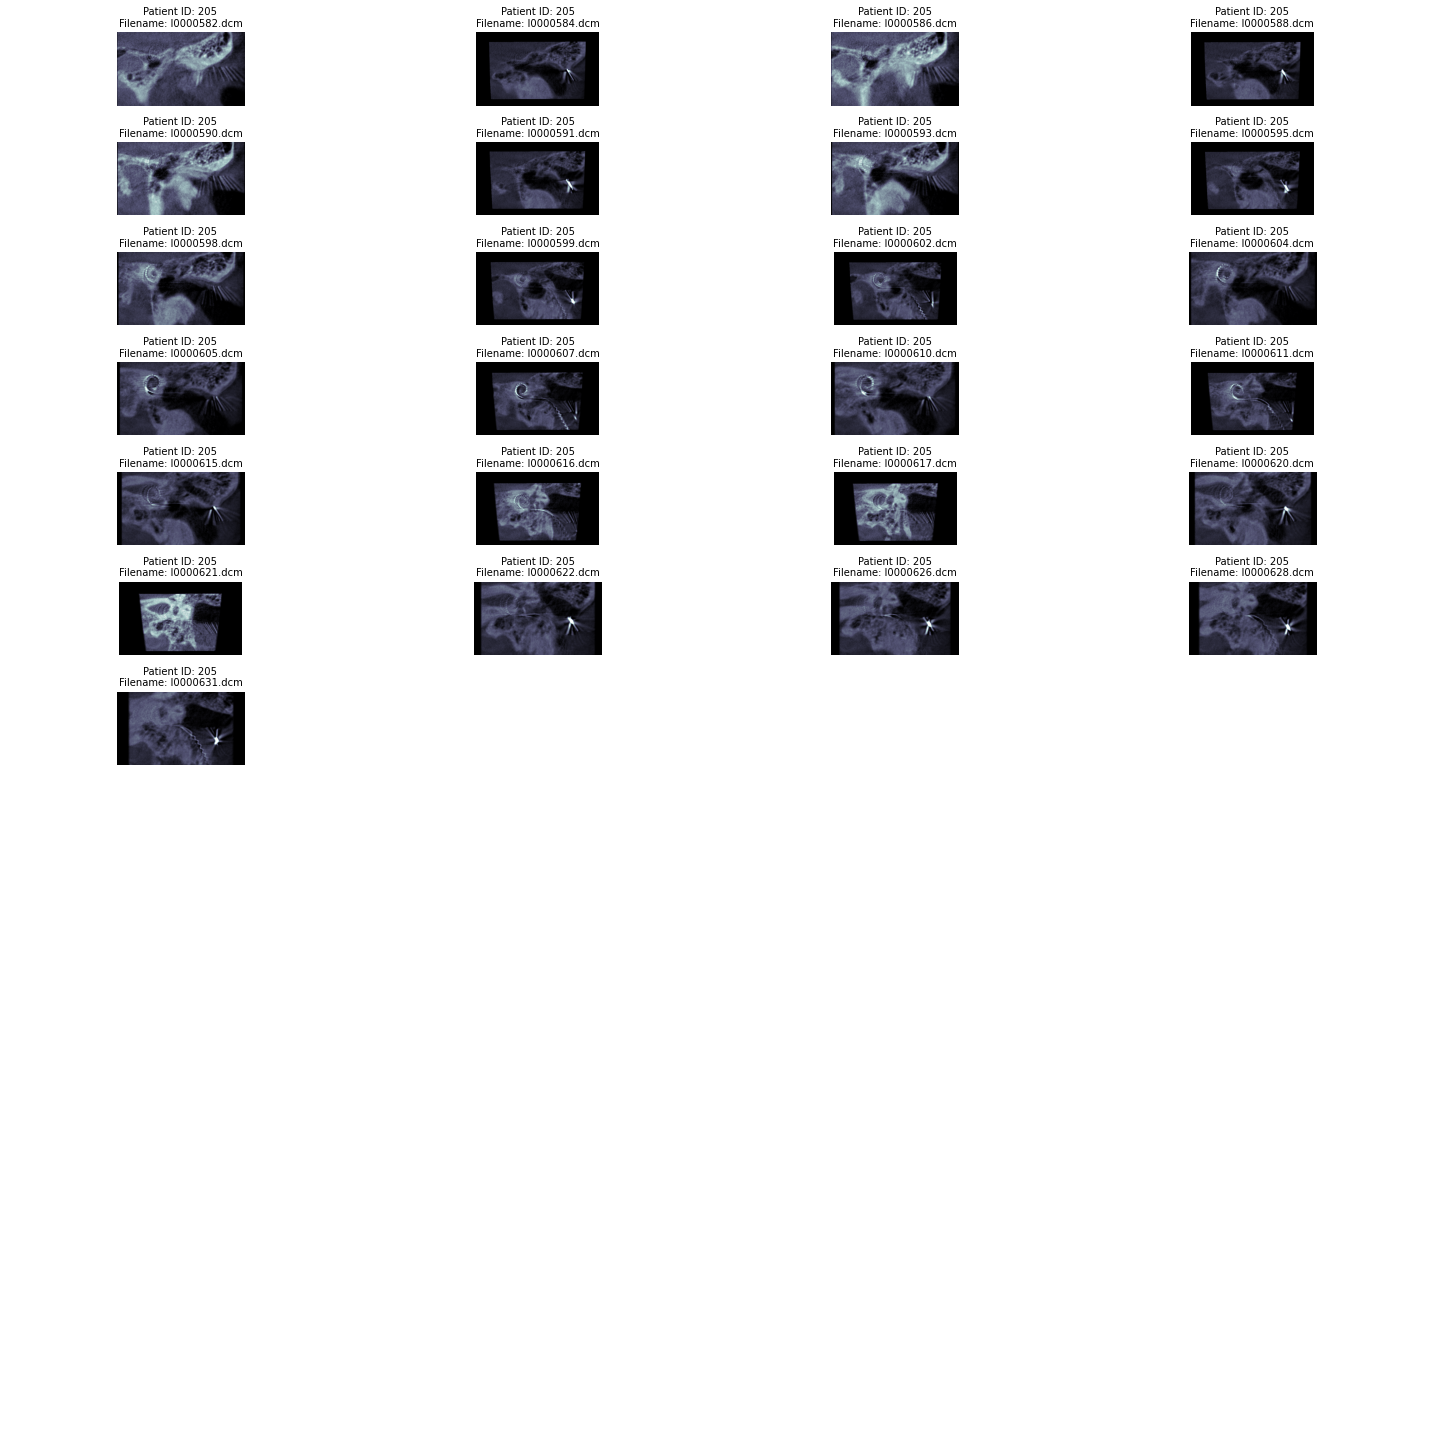

In [14]:
# import os
# import math
# import matplotlib.pyplot as plt
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

def process_and_visualize_dicom_folder(dicom_folder, output_filename, cols=4, display_figure=True):
    """
    Process DICOM files in a specified folder and visualize them in a grid layout.

    Parameters:
    - dicom_folder: Path to the folder containing DICOM files.
    - output_filename: Path where the output figure should be saved.
    - cols: Number of columns in the grid layout for displaying images.
    - display_figure: Whether to display the figure in a window (True) or not (False).
    """
    # # Explicitly set the GDCM handler if it is installed
    # pydicom.config.image_handlers = ['gdcm_handler'] if 'gdcm_handler' in pydicom.config.available_handlers else pydicom.config.image_handlers

    # List DICOM files in the folder
    dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]

    # Calculate the number of images and the layout
    num_images = len(dicom_files)
    rows = math.ceil(num_images / cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust the figure size as needed
    axes = axes.flatten()

    processed_images_count = 0  # Keep track of the number of successfully processed images

    for i, dicom_file in enumerate(dicom_files):
        try:
            file_path = os.path.join(dicom_folder, dicom_file)
            dicom_data = pydicom.dcmread(file_path, force=True)

            # Some DICOM files may not have the PixelData field
            if 'PixelData' not in dicom_data:
                continue

            # Use matplotlib to display the images
            image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
            axes[processed_images_count].imshow(image, cmap=plt.cm.bone)
            axes[processed_images_count].axis('off')  # Hide the axis
            axes[processed_images_count].set_title(f"Patient ID: {dicom_data.PatientID}\nFilename: {dicom_file}", fontsize=10)
            processed_images_count += 1  # Increment the count of processed images
        except Exception as e:
            print(f"An error occurred for file {dicom_file}: {e}")
            continue  # Skip files that cause errors

    # Hide any unused subplots
    for ax in axes[processed_images_count:]:
        ax.axis('off')

    plt.tight_layout()
    # Save the figure to a file
    plt.savefig(output_filename, dpi=300)
    if display_figure:
        plt.show()
    plt.close()

# Example usage
dicom_folder = "/Volumes/Yunyao-2024/CI Data/205/Coronal"
output_filename = "/Volumes/Yunyao-2024/CI Data/205/Coronal/Patient205_all_Coronal.png"
process_and_visualize_dicom_folder(dicom_folder, output_filename, cols=4, display_figure=True)


# Image inspectation
- load 1 DICOM, print the info, and see what can we do with it
- From this section, we know the tags they set, and we are interested in 
    - patient ID
    - ImageOrientationPatient
    - image dimensions
    - PixelData


Patient ID: 204
Image Orientation Patient: [1.0, -0.0, -0.0, 0.0, 0.0, -1.0]
Image Dimensions: (502, 728)


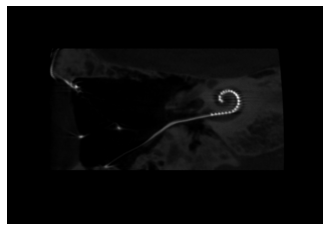

In [7]:
# get corrent path
# print(os.getcwd())

# Path to your DICOM file
# path = "/Users/yunyao/Desktop/Capstone/Data/200/DICOM/I0000023.dcm"

# path = "/Volumes/Yunyao-2024/CI Data/204/DICOM/I0000594.dcm"


# Replace with the path to your DICOM file
dicom_path = "/Volumes/Yunyao-2024/CI Data/204/DICOM/I0000594.dcm"

# Read the DICOM file
ds = pydicom.dcmread(dicom_path)

# ---------- Uncomment this section to check all the tags-----------
# print("All available information in the DICOM file:")
# for tag in ds.dir():
#     try:
#         value = getattr(ds, tag)
#         print(f"{tag}: {value}")
#     except AttributeError:
#         print(f"{tag}: Attribute not found")
#--------------------------------------------------------------------

# Extract and print basic information
print("Patient ID:", ds.get("PatientID", "Not available"))
image_orientation_patient = ds.get("ImageOrientationPatient", "Not available")
# If image position patient is available, round the coordinates
if image_orientation_patient != "Not available":
    image_orientation_patient = [round(coord, 0) for coord in image_orientation_patient]
print("Image Orientation Patient:", image_orientation_patient)


# Check if the file has image data and print dimensions
if "pixel_array" in dir(ds):
    print("Image Dimensions:", ds.pixel_array.shape)
else:
    print("Image data not available")

try:
    # Read the DICOM file
    ds = pydicom.dcmread(dicom_path)

    # Display the image
    plt.imshow(ds.pixel_array, cmap="gray")
    plt.axis('off')  # Optional: to turn off axis labels and ticks
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

# Filter
To create a function that processes all DICOM images in a given folder, checks their `ImageOrientationPatient` attribute, rounds its values to one decimal place, and duplicates the image to a specified folder if the orientation matches `(1,0,0,0,0,-1)`, you will need to use the `pydicom` library for reading DICOM files and the `shutil` library for copying files.

Here is a step-by-step approach to write this function:

1. **Iterate Over All DICOM Files**: Read each DICOM file in the specified folder.

2. **Check `ImageOrientationPatient`**: Extract this attribute from each DICOM file, round the values to one decimal place, and check if it matches the specified orientation.

3. **Copy Matching Files**: If an image matches the criteria, duplicate it to the specified target folder.

Here's the Python code to implement this:


This function will process each DICOM file in the `source_folder`, check the `ImageOrientationPatient` attribute, and if the condition is met, it will copy the file to the `target_folder`. Remember to ensure that the path to the folders is correct and accessible in your environment.

In [8]:
# import os
# import pydicom
import shutil
def is_valid_orientation(orientation):
    # Check if the orientation is a list and has 6 numeric elements
    return isinstance(orientation, list) and len(orientation) == 6 and all(isinstance(num, float) for num in orientation)

def copy_coronal_images(source_folder, target_folder):
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # Loop through all files in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith('.dcm'):  # Check if it's a DICOM file
            file_path = os.path.join(source_folder, filename)

            # Read the DICOM file
            ds = pydicom.dcmread(file_path,force=True)

            # Check if ImageOrientationPatient attribute exists, is not None, and is valid
            if hasattr(ds, 'ImageOrientationPatient') and ds.ImageOrientationPatient:
                orientation = ds.ImageOrientationPatient
                

                if hasattr(ds, 'ImageOrientationPatient'):
                # if is_valid_orientation(orientation):
                #     # Round the orientation values to one decimal place
                    rounded_orientation = [round(val, 0) for val in orientation]
                    # print(filename)

                    # Check if the orientation matches (1,0,0,0,0,-1)
                    if rounded_orientation == [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]:
                        # Copy the file to the target folder
                        shutil.copy(file_path, os.path.join(target_folder, filename))
                        print(f"Copied: {filename}")

# Define source and target folders
source_folder = "/Volumes/Yunyao-2024/CI Data/205/DICOM"
target_folder = "/Volumes/Yunyao-2024/CI Data/205/Coronal"

# Call the function
copy_coronal_images(source_folder, target_folder)



Copied: I0000577.dcm
Copied: I0000582.dcm
Copied: I0000584.dcm
Copied: I0000586.dcm
Copied: I0000588.dcm
Copied: I0000590.dcm
Copied: I0000591.dcm
Copied: I0000593.dcm
Copied: I0000595.dcm
Copied: I0000598.dcm
Copied: I0000599.dcm
Copied: I0000602.dcm
Copied: I0000604.dcm
Copied: I0000605.dcm
Copied: I0000607.dcm
Copied: I0000610.dcm
Copied: I0000611.dcm
Copied: I0000615.dcm
Copied: I0000616.dcm
Copied: I0000617.dcm
Copied: I0000620.dcm
Copied: I0000621.dcm
Copied: I0000622.dcm
Copied: I0000626.dcm
Copied: I0000628.dcm
Copied: I0000631.dcm


# Convert the selected DICOM file into JPEG for annotation in labelme
This script does the following:

- Creates a "JPEG" directory within the specified base directory if it doesn't already exist.
- Iterates through each DICOM file in the "Coronal" directory, converting each to a JPEG image.
- Saves the JPEG images in the "JPEG" directory.

DICOM files can contain multiple images and various types of medical data, so this script assumes that the DICOM files contain a single image in a format that can be converted directly to a JPEG image. If the DICOM files are more complex, additional processing may be required.

In [46]:
import os
import shutil

def process_patient_files(source_dir, destination_dir):
    # Check if destination subdirectory exists, if not create it
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    # Iterate over patient directories
    for patient_dir in os.listdir(source_dir):
        patient_path = os.path.join(source_dir, patient_dir)
        
        # Check if the path is a directory
        if os.path.isdir(patient_path):
            coronal_path = os.path.join(patient_path, 'Coronal')
            
            # Check if the coronal directory exists
            if os.path.exists(coronal_path):
                # Copy all dcm files to the destination while renaming
                for file_name in os.listdir(coronal_path):
                    if file_name.endswith('.dcm'):
                        # Define the new file path with patientID prefixed
                        new_file_name = f"{patient_dir}_{file_name}"
                        new_file_path = os.path.join(destination_dir, new_file_name)
                        
                        # Copy the file to the new location
                        shutil.copy2(os.path.join(coronal_path, file_name), new_file_path)

# Use the function
source_directory = '/Volumes/Yunyao-2024/CI Data' # Change this to your actual source directory path
destination_directory = '/Volumes/Yunyao-2024/CI Data/Processed/all_coronal' # Change this to your actual destination directory path
process_patient_files(source_directory, destination_directory)


In [ ]:
# # import os
# # import shutil

# def process_dicom_files(base_dir, processed_subdir='Processed/all_coronal'):
#     """
#     Goes through each patient folder within the patient range directories, excluding 'Processed',
#     copies all .dcm files from the 'Coronal' subfolder, and pastes them into the 'Processed/all_coronal'
#     directory, prefixing the filenames with the patient ID.

#     :param base_dir: Path to the base directory containing the CI Data and patient range folders.
#     :param processed_subdir: The subdirectory within the base directory for processed files.
#     """
#     processed_coronal_dir = os.path.join(base_dir, processed_subdir)
#     if not os.path.exists(processed_coronal_dir):
#         os.makedirs(processed_coronal_dir)

#     # Go through each range folder like '200-210', '211-220', etc., excluding 'Processed'
#     for range_folder in os.listdir(base_dir):
#         if range_folder.lower() == 'Processed':
#             continue  # Skip the 'Processed' folder
        
#         range_folder_path = os.path.join(base_dir, range_folder)

#         # Only proceed if it's a directory
#         if os.path.isdir(range_folder_path):
#             # Go through each patient folder in the range directory
#             for patient_folder in os.listdir(range_folder_path):
#                 patient_folder_path = os.path.join(range_folder_path, patient_folder)

#                 # Skip if the folder is 'Processed'
#                 if patient_folder.lower() == 'processed':
#                     continue

#                 # Only proceed if it's a directory
#                 if os.path.isdir(patient_folder_path):
#                     coronal_path = os.path.join(patient_folder_path, 'Coronal')

#                     # Print to show which folder is being processed
#                     print(f"Processing {coronal_path}...")

#                     # Check if 'Coronal' folder exists
#                     if os.path.exists(coronal_path):
#                         # Copy each .dcm file if it doesn't already exist in the destination
#                         for file_name in os.listdir(coronal_path):
#                             if file_name.endswith('.dcm'):
#                                 source_file = os.path.join(coronal_path, file_name)
#                                 new_file_name = f"{patient_folder}_{file_name}"
#                                 destination_file = os.path.join(processed_coronal_dir, new_file_name)

#                                 # Check if the file already exists in the processed directory
#                                 if not os.path.exists(destination_file):
#                                     shutil.copy2(source_file, destination_file)
#                                     print(f"Copied {file_name} to {processed_coronal_dir} as {new_file_name}")
#                                 else:
#                                     print(f"File {new_file_name} already exists, skipping.")

# # Specify the base directory (where the CI Data directory is located)
# base_dir = '/Volumes/Yunyao-2024/CI Data'

# # Run the function with printing enabled to track the process
# process_dicom_files(base_dir)

# # As before, the print statements and actual file operations won't execute on this platform. 
# # This script should be run in a local environment where you have access to the filesystem.



In [ ]:
import os
import pydicom
import numpy as np
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
#----------------------------------------------------------------------
# Convert all the filtered DICOM files into JPET for later annotation
#----------------------------------------------------------------------
dicom_folder = "/Volumes/Yunyao-2024/CI Data/Processed/all_coronal"
jpeg_folder = "/Volumes/Yunyao-2024/CI Data/Processed/all_coronal_JPEG"

# Create the JPEG directory if it does not exist
if not os.path.exists(jpeg_folder):
    os.makedirs(jpeg_folder)

# Loop through all DICOM files in the folder
for dicom_file in os.listdir(dicom_folder):
    if dicom_file.endswith('.dcm'):
        try:
            # Read the DICOM file
            file_path = os.path.join(dicom_folder, dicom_file)
            dicom_data = pydicom.dcmread(file_path, force=True)
            
            # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to
            # "human-friendly" view
            image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
            
            # Depending on this value, X-ray may look inverted - fix that:
            if dicom_data.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
            
            # Convert to uint8 (if necessary)
            if image.dtype != np.uint8:
                image = image - np.min(image)
                image = image / np.max(image)
                image = (image * 255).astype(np.uint8)
            
            # Convert to PIL Image
            im = Image.fromarray(image)
            
            # Save the image
            jpeg_file_path = os.path.join(jpeg_folder, dicom_file.replace('.dcm', '.jpeg'))
            im.save(jpeg_file_path)
            
            print(f"Converted and saved: {jpeg_file_path}")

        except Exception as e:
            print(f"An error occurred while converting {dicom_file}: {e}")



# https://pypi.org/project/dicom2jpg/ 

# Process all (Completed, only run one time, don't overwrite)

In [ ]:
# # import os
# # import pydicom
# # import shutil
# # import matplotlib.pyplot as plt
# # from pydicom.pixel_data_handlers.util import apply_voi_lut

# def is_valid_orientation(orientation):
#     # Check if the orientation is a list and has 6 numeric elements
#     return isinstance(orientation, list) and len(orientation) == 6 and all(isinstance(num, float) for num in orientation)


# def copy_coronal_images(source_folder, target_folder):
#     # Create target folder if it doesn't exist
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)
    
#     # Loop through all files in the source folder
#     for filename in os.listdir(source_folder):
#         if filename.endswith('.dcm'):  # Check if it's a DICOM file
#             file_path = os.path.join(source_folder, filename)
#             ds = pydicom.dcmread(file_path, force=True)  # Read the DICOM file

#             # Check if ImageOrientationPatient attribute exists and is valid
#             if hasattr(ds, 'ImageOrientationPatient') and ds.ImageOrientationPatient:
#                 orientation = ds.ImageOrientationPatient
#                 rounded_orientation = [round(val, 0) for val in orientation]

#                 # Check if the orientation matches coronal images
#                 if rounded_orientation == [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]:
#                     shutil.copy(file_path, os.path.join(target_folder, filename))  # Copy the file
#                     print(f"Copied: {filename}")


# def process_and_visualize_dicom_folder(dicom_folder, output_filename, cols=4, display_figure=True):
#     # List DICOM files in the folder
#     dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]

#     # Calculate the number of images and the layout
#     num_images = len(dicom_files)
#     if num_images == 0:
#         print(f"No DICOM files found in {dicom_folder}. Skipping visualization.")
#         return  # Exit the function if no DICOM files are found

#     rows = math.ceil(num_images / cols)

#     # Create a figure with subplots
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Adjust the figure size as needed
#     if rows * cols > 1:
#         axes = axes.flatten()
#     else:
#         axes = [axes]

#     processed_images_count = 0  # Keep track of the number of successfully processed images

#     for i, dicom_file in enumerate(dicom_files):
#         try:
#             file_path = os.path.join(dicom_folder, dicom_file)
#             dicom_data = pydicom.dcmread(file_path, force=True)

#             # Some DICOM files may not have the PixelData field
#             if 'PixelData' not in dicom_data:
#                 continue

#             # Use matplotlib to display the images
#             image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
#             axes[processed_images_count].imshow(image, cmap=plt.cm.bone)
#             axes[processed_images_count].axis('off')  # Hide the axis
#             axes[processed_images_count].set_title(f"Patient ID: {dicom_data.PatientID}\nFilename: {dicom_file}", fontsize=10)
#             processed_images_count += 1  # Increment the count of processed images
#         except Exception as e:
#             print(f"An error occurred for file {dicom_file}: {e}")
#             continue  # Skip files that cause errors

#     # Hide any unused subplots
#     for ax in axes[processed_images_count:]:
#         ax.axis('off')

#     plt.tight_layout()
#     # Save the figure to a file
#     plt.savefig(output_filename, dpi=300)
#     if display_figure:
#         plt.show()
#     plt.close()

# def process_all_patients(base_folder, output_folder, cols=4, display_figure=False):
#     # Ensure the output folder exists
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
#             # Skip the "Processed" folder and ensure we're only processing directories
        

#     # Iterate through each patientID folder
#     for patient_id in os.listdir(base_folder):
#         patient_folder = os.path.join(base_folder, patient_id)
        
#         # Skip the "Processed" folder and ensure we're only processing directories
#         if patient_id == "Processed" or not os.path.isdir(patient_folder):
#             continue

#         if not os.path.isdir(patient_folder):  # Skip files, process only directories
#             continue
#         dicom_folder = os.path.join(patient_folder, "DICOM")
#         coronal_folder = os.path.join(patient_folder, "Coronal")

#         # Filter and copy coronal images to the "Coronal" folder
#         print(f"Filtering coronal images for patient {patient_id}...")
#         copy_coronal_images(dicom_folder, coronal_folder)

#         # Process and visualize the filtered coronal images
#         print(f"Processing and visualizing coronal images for patient {patient_id}...")
#         output_filename = os.path.join(output_folder, f"Patient{patient_id}_all_Coronal.png")
#         process_and_visualize_dicom_folder(coronal_folder, output_filename, cols=cols, display_figure=display_figure)
       

# # Example usage
# # base_folder = "/Volumes/Yunyao-2024/CI Data"
# base_folder = "/Volumes/Yunyao-2024/306-330"
# output_folder = "/Volumes/Yunyao-2024/CI Data/Processed/all_coronal_preview"
# process_all_patients(base_folder, output_folder, cols=4, display_figure=False)


# Always clean the data

In [1]:
import os

def clean_data(base_dir):
    """
    Cleans the data by deleting files that start with '._' or contain '_._' in the filename.

    :param base_dir: Path to the base directory containing all data.
    """
    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(base_dir):
        for filename in filenames:
            # Check if the file starts with '._' or contains '_._'
            if filename.startswith('._') or '_._' in filename:
                file_to_delete = os.path.join(dirpath, filename)
                os.remove(file_to_delete)  # Delete the file
                print(f"Deleted {file_to_delete}")

# Specify the base directory (where the CI Data directory is located)
base_dir = '/Volumes/Yunyao-2024'

# Run the function to clean the data
clean_data(base_dir)